In [280]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.pixelcnn import PixelCNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [281]:
IMAGE_SIZE = 28
BATCH_SIZE = 32

In [282]:
artifact_path = Path("../../artifacts/pixelcnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/mnist")

In [283]:
DEVICE = torch.device("cuda:0")

# Data

In [284]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [285]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

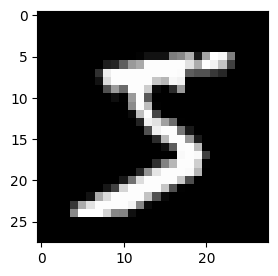

In [286]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]), cmap="gray")

In [287]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().squeeze_(1)

In [288]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [289]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32, 28, 28])


# Model

In [290]:
model = PixelCNN(
    1,
    256,
    hidden_dim=128,
    num_layer=12,
)

In [291]:
import torchinfo

torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
PixelCNN                                      --
├─Sequential: 1-1                             --
│    └─MaskedConv2d: 2-1                      12,800
├─Sequential: 1-2                             --
│    └─ResBlock: 2-2                          --
│    │    └─ReLU: 3-1                         --
│    │    └─BottleNeck: 3-2                   213,504
│    │    └─Identity: 3-3                     --
│    └─ResBlock: 2-3                          (recursive)
│    │    └─ReLU: 3-4                         --
│    │    └─BottleNeck: 3-5                   (recursive)
│    │    └─Identity: 3-6                     --
│    └─ResBlock: 2-4                          (recursive)
│    │    └─ReLU: 3-7                         --
│    │    └─BottleNeck: 3-8                   (recursive)
│    │    └─Identity: 3-9                     --
│    └─ResBlock: 2-5                          (recursive)
│    │    └─ReLU: 3-10                        --
│    │    

# train

In [292]:
EPOCH = 10

In [293]:
trainer = ClassificationTrainer(EPOCH, DEVICE)

In [294]:
trainer.recorder.increment_data_size(len(train_data))

In [295]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [296]:
scaler = torch.cuda.amp.GradScaler()

In [297]:
training_loss = trainer.run(train_loader, model, optim, criterion, scaler=scaler)

Enable AMP: True
Training...


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:52<00:00, 35.60it/s]


------------------------------------
Epoch 1
------------------------------------
0.02592383276422818 (0%)


100%|██████████| 1875/1875 [00:55<00:00, 33.98it/s]


------------------------------------
Epoch 2
------------------------------------
0.02399549488822623 (-7%)


100%|██████████| 1875/1875 [00:56<00:00, 33.36it/s]


------------------------------------
Epoch 3
------------------------------------
0.023513731980323818 (-2%)


100%|██████████| 1875/1875 [00:53<00:00, 34.77it/s]


------------------------------------
Epoch 4
------------------------------------
0.023164302148421592 (-1%)


100%|██████████| 1875/1875 [00:54<00:00, 34.32it/s]


------------------------------------
Epoch 5
------------------------------------
0.022873571109771736 (-1%)


100%|██████████| 1875/1875 [00:55<00:00, 33.92it/s]


------------------------------------
Epoch 6
------------------------------------
0.022608987789352736 (-1%)


100%|██████████| 1875/1875 [00:52<00:00, 35.94it/s]


------------------------------------
Epoch 7
------------------------------------
0.02223453600108625 (-2%)


100%|██████████| 1875/1875 [00:52<00:00, 36.02it/s]


------------------------------------
Epoch 8
------------------------------------
0.022011142484347032 (-1%)


100%|██████████| 1875/1875 [00:54<00:00, 34.69it/s]


------------------------------------
Epoch 9
------------------------------------
0.021758735261360827 (-1%)


100%|██████████| 1875/1875 [00:52<00:00, 35.81it/s]

------------------------------------
Epoch 10
------------------------------------
0.021502904935677847 (-1%)


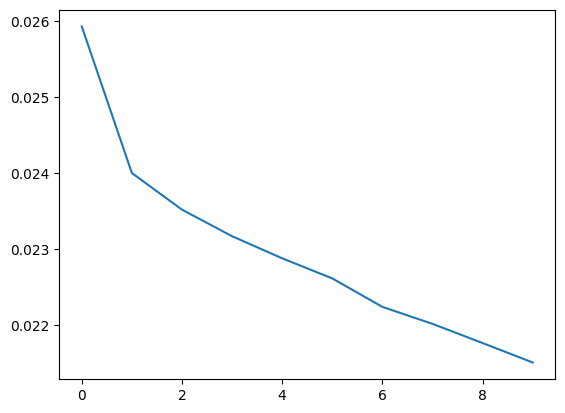

In [298]:
plt.plot(training_loss)

In [299]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('pixelcnn.d{hidden_dim}.l{num_layer}.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layer)

In [300]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\pixelcnn\pixelcnn.d128.l12.pth, model size is 1.2MiB


In [301]:
manager.load_weight(model_path, model)

# evaluation

In [303]:
TEST_BATCH_SIZE = 16

784it [00:05, 147.19it/s]


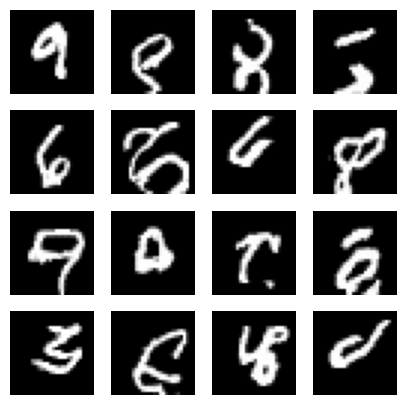

In [311]:
from itertools import product


model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(1))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)])[:, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    img_tensor_to_np(placeholder), 
    cmap='gray',
    num_col=4,
    num_row=4,
    figsize=(5,5),
)